# **Identifying Key Entities in Recipe Data**

[link text](https://)
**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [ ]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [ ]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ingredient_and_quantity.json to ingredient_and_quantity.json


## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>


#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [ ]:
# define a function to load json file to a dataframe

def load_json_dataframe(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [ ]:
# read the json file by giving the file path and create a dataframe
inputDF = load_json_dataframe("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [ ]:
# display first five rows of the dataframe - df
inputDF.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [ ]:
# print the dimensions of dataframe - df
inputDF.shape

(285, 2)

In [ ]:
# print the information of the dataframe
inputDF.info

<bound method DataFrame.info of                                                                                                                                                                                                                                                                                               input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                   6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                      2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                    1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3    500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                             1 tablespoon chana dal white urad 2 red chillies coriander seeds 

#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [ ]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

nlp = spacy.load("en_core_web_sm")
# Tokenize input
inputDF['input_tokens'] = inputDF['input'].apply(lambda text: [token.text for token in nlp(text)])

# Tokenize POS
inputDF['pos_tokens'] = inputDF['pos'].apply(lambda text: [token.text for token in nlp(text)])


In [ ]:
# display first five rows of the dataframe - df
inputDF.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                        [2, -, 1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1, -, 1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [ ]:
# create input_length and pos_length columns for the input_tokens and pos-tokens

inputDF['input_length'] = inputDF['input_tokens'].apply(len)

inputDF['pos_length'] = inputDF['pos_tokens'].apply(len)

In [ ]:
# check for the equality of input_length and pos_length in the dataframe

inputDF['lengths_equal'] = inputDF['input_length'] == inputDF['pos_length']

In [ ]:
inputDF.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length  lengths_equal
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31           True
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                        [2, -, 1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, o

In [ ]:
## number of mismatch input tokens and pos tokens
false_count = (inputDF['lengths_equal'] == False).sum()
false_count

np.int64(81)

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [ ]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df, column='pos'):
    all_labels = set()

    for labels in df[column]:
        label_list = labels.split()
        all_labels.update(label_list)

    print("Unique POS labels in the recipe:")
    for label in sorted(all_labels):
        print(label)

unique_labels(inputDF)

Unique POS labels in the recipe:
ingredient
quantity
unit


In [ ]:
inputDF.shape

(285, 7)

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>
The DataFrame contains 81 rows where the input_length and pos_length values do not match, as indicated by the lengths_equal column being False. These rows likely require cleaning and formatting.

Below are unique POS labels:
*  ingredient
*  quantity
*  unit

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [ ]:
# drop the irrelevant recipe data
inputDF = inputDF[inputDF['lengths_equal'] == True]

inputDF.shape

(204, 7)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [ ]:
# update the input and pos length in input_length and pos_length

inputDF['input_length'] = inputDF['input_tokens'].apply(len)
inputDF['pos_length'] = inputDF['pos_tokens'].apply(len)


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [ ]:
# validate the input length and pos length as input_length and pos_length
inputDF['lengths_equal'] = inputDF['input_length'] & inputDF['pos_length']



In [ ]:
inputDF.shape

(204, 7)

In [ ]:
df_clean = inputDF[['input_tokens', 'pos_tokens']]
df_clean.head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
3  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]  [quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]
4                                                                                                                                                                                    [1, tablespoon, chana, dal, white, urad, 2, red, chillies, coriander, seeds, 3, inches, ginger, onion, tomato, Teaspoon, mustard, asafoetida, sprig, curry]                                                                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient]
5                                              [1, cup, Rice, 1/2, Yellow, Moong, Dal, Mint, Leaves, 1/4, Coriander, Dhania, Green, Chilli, inch, Ginger, teaspoon, Cumin, seeds, 5, cups, Water, Sunflower, Oil, Salt, 2, tablespoons, Ghee, 8, Cashew, nuts, halved, Whole, Black, Peppercorns, sprig, Curry, leaves, pinch, Asafoetida, hing]                                                                  [quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient]
6                                               [500, grams, Vellai, Poosanikai, 1/2, teaspoon, Turmeric, powder, Salt,

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</fo

```
# This is formatted as code
```

nt> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.



```
# This is formatted as code
```

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

> Add blockquote



In [ ]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df_clean, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [ ]:
# print the first five rows of train_df
train_df.head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                  pos_tokens
132  [1, cup, Gram, flour, besan, 1/2, teaspoon, Ajwain, Carom, seeds, 1/4, Red, Chilli, powder, 2, tablespoons, Curd, Dahi, Yogurt, Sunflower, Oil, Green, Bell, Pepper, Capsicum, Cumin, Asafoetida, hing, Turmeric, Garam, masala, Amchur, Dry, Mango, Powder, Coriander, Dhania, 4, sprig, Leaves, chopped]  [quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]
39                                                                                                                                        [1, eggplant, 2, inch, ginger, onion, tomato, green, chillies, teaspoon, turmeric, powder, garam, masala, coriander, tablespoon, butter, red, chili, oil, sprigs, of]                                                                                                                                                                                                                                [quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient]
15                                                                                                                               [2, onions, 1, teaspoon, cumin, seeds, tablespoons, black, urad, dal, split, tamarind, paste, 3, dry, red, chillies, 1/2, jaggery, teaspoons, oil, salt, sprig, curry, leaves]                                                                                                                                                                                                [quantity, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient]
44                                                                                                                     [2, cups, Makki, Ka, Atta, Yellow, Corn, Meal, Flour, 1, 1/2, Methi, Leaves, Fenugreek, chopped, Green, Chillies, tablespoon, Ajwain, Carom, seeds, Kashmiri, Red, Chilli, Powder, Salt]                                                                                                                                                                      [quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
166                                                                [10, prawns, 1, tablespoon, soy, sauce, teaspoon, sesame, gingelly, oil, cloves, garlic, finely, chopped, 2, green, chillies, coriander, dhania, leaves, 1/2, whole, black, peppercorns, crushed, sunflower, salt, few, drops, lemon, juice]                                                                                                              [quantity, ingredient, quantity, unit, ingredient, ingredi

In [ ]:
# print the first five rows of the val_df
val_df.head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens
19                                                                                                                                                                                [1, cup, rice, 12, small, onions, 2, cloves, garlic, inch, ginger, green, chillies, bay, leaf, tsp, red, chilli, powder, turmeric, carrot, beans, potatoes, ghee, cinnamon, fennel, whole, pepper, coriander, seeds, 1/4, peas, mint, leaves]                                                                                                                                                                                                                                                                  [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]
11   [2, Burger, buns, 5, Pickled, Jalapenos, sliced, Cheese, Slices, Potatoes, Aloo, pressure, cooked, 1, Onion, chopped, tablespoon, Red, Chilli, powder, Salt, Whole, Egg, 1/2, cup, Wheat, Bread, crumbs, 4, cloves, Garlic, Onions, Tomatoes, Homemade, tomato, puree, Green, Bell, Pepper, Capsicum, Soy, granules, teaspoon, flakes, Cumin, Jeera, Dried, oregano, Tabasco, Original, Hot, Sauce, Honey, Sunflower, Oil]  [quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
155                                                                                                                                                                                                                                                                     [1/4, cup, Rice, Yellow, Moong, Dal, 1, Carrot, Gajjar, 3, Green, beans, French, Beans, teaspoon, Ghee, Cumin, seeds, Asafoetida, hing, Salt, a, pinch]                                                                                                                                                                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit]
105                                                                                                                              [4, Potatoes, Aloo, 50, grams, Mozzarella, cheese, 1, teaspoon, Mustard, seeds, inch, Ginger, grat

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [ ]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens']
y_train = train_df['pos_tokens']

X_val = val_df['input_tokens']
y_val = val_df['pos_tokens']

In [ ]:
# validate the shape of training and validation samples

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((142,), (142,), (62,), (62,))

###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [ ]:
# Display the number of unique labels present in y_train

flat_labels = [label for sublist in y_train for label in sublist]
unique_labels = set(flat_labels)

unique_labels

{'ingredient', 'quantity', 'unit'}

## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>



```
# This is formatted as code
```

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [ ]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [ ]:
# initialise the dataset_name
dataset_name = 'Training'

flat_input = flatten_list(train_df['input_tokens'])
flat_pos = flatten_list(train_df['pos_tokens'])

print("flat_input", flat_input)
print("flat_pos", flat_pos)

flat_input ['1', 'cup', 'Gram', 'flour', 'besan', '1/2', 'teaspoon', 'Ajwain', 'Carom', 'seeds', '1/4', 'Red', 'Chilli', 'powder', '2', 'tablespoons', 'Curd', 'Dahi', 'Yogurt', 'Sunflower', 'Oil', 'Green', 'Bell', 'Pepper', 'Capsicum', 'Cumin', 'Asafoetida', 'hing', 'Turmeric', 'Garam', 'masala', 'Amchur', 'Dry', 'Mango', 'Powder', 'Coriander', 'Dhania', '4', 'sprig', 'Leaves', 'chopped', '1', 'eggplant', '2', 'inch', 'ginger', 'onion', 'tomato', 'green', 'chillies', 'teaspoon', 'turmeric', 'powder', 'garam', 'masala', 'coriander', 'tablespoon', 'butter', 'red', 'chili', 'oil', 'sprigs', 'of', '2', 'onions', '1', 'teaspoon', 'cumin', 'seeds', 'tablespoons', 'black', 'urad', 'dal', 'split', 'tamarind', 'paste', '3', 'dry', 'red', 'chillies', '1/2', 'jaggery', 'teaspoons', 'oil', 'salt', 'sprig', 'curry', 'leaves', '2', 'cups', 'Makki', 'Ka', 'Atta', 'Yellow', 'Corn', 'Meal', 'Flour', '1', '1/2', 'Methi', 'Leaves', 'Fenugreek', 'chopped', 'Green', 'Chillies', 'tablespoon', 'Ajwain', 'Car

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [ ]:

def extract_and_validate_tokens(df, dataset_name):
    flat_input = flatten_list(df['input_tokens'])
    flat_pos = flatten_list(df['pos_tokens'])

    if len(flat_input) != len(flat_pos):
        print(f"[{dataset_name}] Length mismatch: input={len(flat_input)}, pos={len(flat_pos)}")
    else:
        print(f"[{dataset_name}] Lengths match: {len(flat_input)} tokens")

    print(f"\nSample preview from {dataset_name} dataset:")
    for i in range(min(10, len(flat_input))):
        print(f"{i+1}. Token: '{flat_input[i]}' — Label: '{flat_pos[i]}'")

    return flat_input, flat_pos


In [ ]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, 'Training')
extract_and_validate_tokens(val_df, 'Validation')


[Training] Lengths match: 4632 tokens

Sample preview from Training dataset:
1. Token: '1' — Label: 'quantity'
2. Token: 'cup' — Label: 'unit'
3. Token: 'Gram' — Label: 'ingredient'
4. Token: 'flour' — Label: 'ingredient'
5. Token: 'besan' — Label: 'ingredient'
6. Token: '1/2' — Label: 'quantity'
7. Token: 'teaspoon' — Label: 'unit'
8. Token: 'Ajwain' — Label: 'ingredient'
9. Token: 'Carom' — Label: 'ingredient'
10. Token: 'seeds' — Label: 'ingredient'
[Validation] Lengths match: 2149 tokens

Sample preview from Validation dataset:
1. Token: '1' — Label: 'quantity'
2. Token: 'cup' — Label: 'unit'
3. Token: 'rice' — Label: 'ingredient'
4. Token: '12' — Label: 'quantity'
5. Token: 'small' — Label: 'unit'
6. Token: 'onions' — Label: 'ingredient'
7. Token: '2' — Label: 'quantity'
8. Token: 'cloves' — Label: 'ingredient'
9. Token: 'garlic' — Label: 'ingredient'
10. Token: 'inch' — Label: 'unit'


(['1',
  'cup',
  'rice',
  '12',
  'small',
  'onions',
  '2',
  'cloves',
  'garlic',
  'inch',
  'ginger',
  'green',
  'chillies',
  'bay',
  'leaf',
  'tsp',
  'red',
  'chilli',
  'powder',
  'turmeric',
  'carrot',
  'beans',
  'potatoes',
  'ghee',
  'cinnamon',
  'fennel',
  'whole',
  'pepper',
  'coriander',
  'seeds',
  '1/4',
  'peas',
  'mint',
  'leaves',
  '2',
  'Burger',
  'buns',
  '5',
  'Pickled',
  'Jalapenos',
  'sliced',
  'Cheese',
  'Slices',
  'Potatoes',
  'Aloo',
  'pressure',
  'cooked',
  '1',
  'Onion',
  'chopped',
  'tablespoon',
  'Red',
  'Chilli',
  'powder',
  'Salt',
  'Whole',
  'Egg',
  '1/2',
  'cup',
  'Wheat',
  'Bread',
  'crumbs',
  '4',
  'cloves',
  'Garlic',
  'Onions',
  'Tomatoes',
  'Homemade',
  'tomato',
  'puree',
  'Green',
  'Bell',
  'Pepper',
  'Capsicum',
  'Soy',
  'granules',
  'teaspoon',
  'flakes',
  'Cumin',
  'Jeera',
  'Dried',
  'oregano',
  'Tabasco',
  'Original',
  'Hot',
  'Sauce',
  'Honey',
  'Sunflower',
  'Oil

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [ ]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    unit_keywords = {'cup', 'cups', 'tbsp', 'tablespoon', 'tsp', 'teaspoon', 'grams', 'kg', 'g', 'ml', 'l', 'oz'}
    quantity_pos = {'quantity'}
    ingredient_pos = {'ingredient'}
    ingredients, units, quantities = [], [], []

    for token, tag in zip(tokens, pos_tags):
        token_lower = token.lower()
        if token_lower in unit_keywords:
            units.append(token)
        elif tag in quantity_pos:
            quantities.append(token)
        elif tag in ingredient_pos:
            ingredients.append(token)

    if not (ingredients or units or quantities):
        return [], [], []

    return ingredients, units, quantities


In [ ]:
#  call the function to categorise the labels into respective list

categorized_data = []

for i, row in train_df.iterrows():
    tokens = row.get('input_tokens', [])
    pos_tags = row.get('pos_tokens', [])
    ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

    categorized_data.append({
        'Ingredients': ingredients,
        'Units': units,
        'Quantities': quantities
    })

print("categorized_data", categorized_data)

categorized_data [{'Ingredients': ['Gram', 'flour', 'besan', 'Ajwain', 'Carom', 'seeds', 'Red', 'Chilli', 'powder', 'Curd', 'Dahi', 'Yogurt', 'Sunflower', 'Oil', 'Green', 'Bell', 'Pepper', 'Capsicum', 'Cumin', 'Asafoetida', 'hing', 'Turmeric', 'Garam', 'masala', 'Amchur', 'Dry', 'Mango', 'Powder', 'Coriander', 'Dhania', 'Leaves', 'chopped'], 'Units': ['cup', 'teaspoon'], 'Quantities': ['1', '1/2', '1/4', '2', '4']}, {'Ingredients': ['eggplant', 'ginger', 'onion', 'tomato', 'green', 'chillies', 'turmeric', 'powder', 'garam', 'masala', 'coriander', 'butter', 'red', 'chili', 'oil', 'of'], 'Units': ['teaspoon', 'tablespoon'], 'Quantities': ['1', '2']}, {'Ingredients': ['onions', 'cumin', 'seeds', 'black', 'urad', 'dal', 'split', 'tamarind', 'paste', 'dry', 'red', 'chillies', 'jaggery', 'oil', 'salt', 'curry', 'leaves'], 'Units': ['teaspoon'], 'Quantities': ['2', '1', '3', '1/2']}, {'Ingredients': ['Makki', 'Ka', 'Atta', 'Yellow', 'Corn', 'Meal', 'Flour', 'Methi', 'Leaves', 'Fenugreek', 'ch

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [ ]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)

    print(f"\nTop {top_n} {pos_label}s in {dataset_name} data:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items


In [ ]:
# get the top ingredients which are frequently seen in the recipe
all_ingredients = [ingredient for row in categorized_data for ingredient in row['Ingredients']]
top_ingredients = get_top_frequent_items(
    item_list=all_ingredients,
    pos_label='ingredient',
    dataset_name='Training',
    top_n=10
)
top_ingredients


Top 10 ingredients in Training data:
powder: 91
Salt: 68
seeds: 67
Oil: 61
Coriander: 55
chopped: 55
Green: 53
Red: 52
Chilli: 50
Leaves: 49


[('powder', 91),
 ('Salt', 68),
 ('seeds', 67),
 ('Oil', 61),
 ('Coriander', 55),
 ('chopped', 55),
 ('Green', 53),
 ('Red', 52),
 ('Chilli', 50),
 ('Leaves', 49)]

In [ ]:
# get the top units which are frequently seen in the recipe
all_units = [unit for row in categorized_data for unit in row['Units']]

top_units = get_top_frequent_items(
    item_list=all_units,
    pos_label='unit',
    dataset_name='Training',
    top_n=10
)
top_units



Top 10 units in Training data:
teaspoon: 109
cup: 91
tablespoon: 63
grams: 40
cups: 33
tsp: 9
Teaspoon: 3
ml: 2
tbsp: 2
Tbsp: 1


[('teaspoon', 109),
 ('cup', 91),
 ('tablespoon', 63),
 ('grams', 40),
 ('cups', 33),
 ('tsp', 9),
 ('Teaspoon', 3),
 ('ml', 2),
 ('tbsp', 2),
 ('Tbsp', 1)]

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




*Define* a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [ ]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_item_list, label, dataset_name):

    items, counts = zip(*top_item_list)  # Unpack items and their frequencies

    plt.figure(figsize=(10, 6))
    bars = plt.bar(items, counts, color='skyblue', edgecolor='black')
    plt.title(f'Top 10 {label}s in {dataset_name} Data', fontsize=14)
    plt.xlabel(f'{label.capitalize()}s', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 str(count), ha='center', va='bottom')

    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



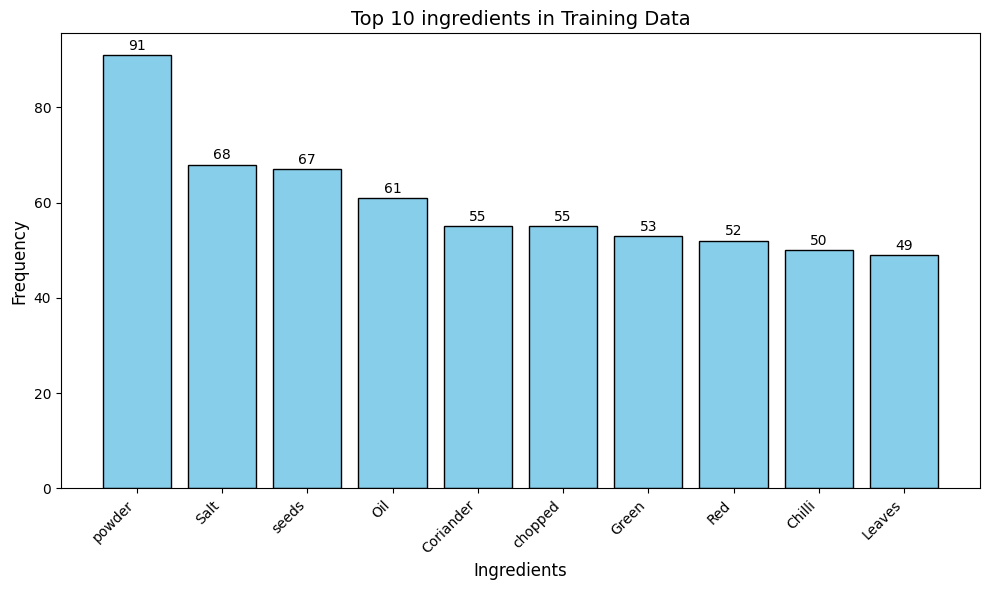

In [ ]:
# plot the top frequent ingredients in training data
plot_top_items(top_item_list=top_ingredients, label='ingredient', dataset_name='Training')

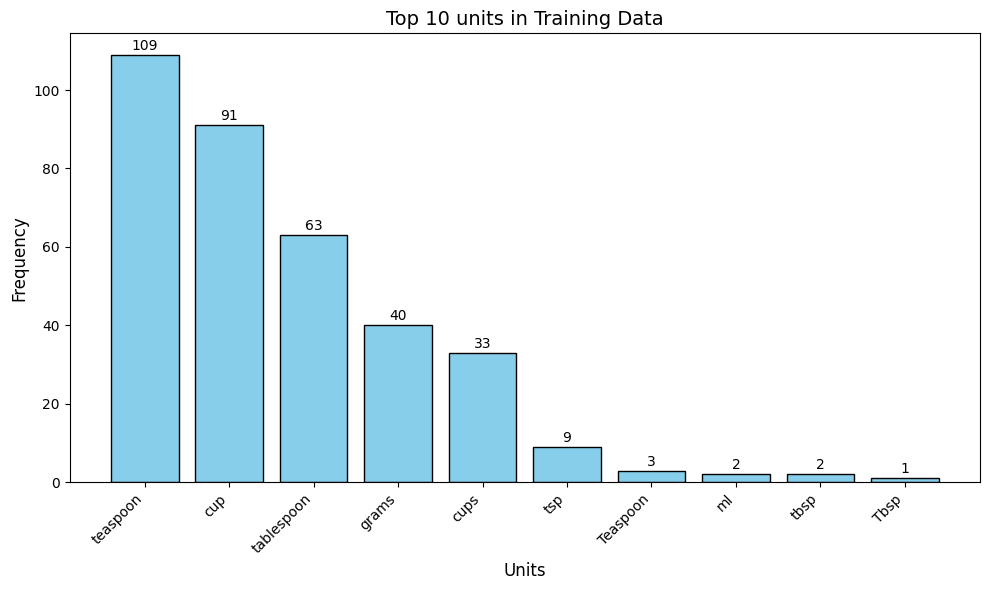

In [ ]:
# plot the top frequent units in training data
plot_top_items(top_item_list=top_units, label='unit', dataset_name='Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


*italicised text*## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

In [ ]:
train_df.head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                  pos_tokens
132  [1, cup, Gram, flour, besan, 1/2, teaspoon, Ajwain, Carom, seeds, 1/4, Red, Chilli, powder, 2, tablespoons, Curd, Dahi, Yogurt, Sunflower, Oil, Green, Bell, Pepper, Capsicum, Cumin, Asafoetida, hing, Turmeric, Garam, masala, Amchur, Dry, Mango, Powder, Coriander, Dhania, 4, sprig, Leaves, chopped]  [quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]
39                                                                                                                                        [1, eggplant, 2, inch, ginger, onion, tomato, green, chillies, teaspoon, turmeric, powder, garam, masala, coriander, tablespoon, butter, red, chili, oil, sprigs, of]                                                                                                                                                                                                                                [quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient]
15                                                                                                                               [2, onions, 1, teaspoon, cumin, seeds, tablespoons, black, urad, dal, split, tamarind, paste, 3, dry, red, chillies, 1/2, jaggery, teaspoons, oil, salt, sprig, curry, leaves]                                                                                                                                                                                                [quantity, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient]
44                                                                                                                     [2, cups, Makki, Ka, Atta, Yellow, Corn, Meal, Flour, 1, 1/2, Methi, Leaves, Fenugreek, chopped, Green, Chillies, tablespoon, Ajwain, Carom, seeds, Kashmiri, Red, Chilli, Powder, Salt]                                                                                                                                                                      [quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
166                                                                [10, prawns, 1, tablespoon, soy, sauce, teaspoon, sesame, gingelly, oil, cloves, garlic, finely, chopped, 2, green, chillies, coriander, dhania, leaves, 1/2, whole, black, peppercorns, crushed, sunflower, salt, few, drops, lemon, juice]                                                                                                              [quantity, ingredient, quantity, unit, ingredient, ingredi

In [ ]:
val_df.head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens
19                                                                                                                                                                                [1, cup, rice, 12, small, onions, 2, cloves, garlic, inch, ginger, green, chillies, bay, leaf, tsp, red, chilli, powder, turmeric, carrot, beans, potatoes, ghee, cinnamon, fennel, whole, pepper, coriander, seeds, 1/4, peas, mint, leaves]                                                                                                                                                                                                                                                                  [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]
11   [2, Burger, buns, 5, Pickled, Jalapenos, sliced, Cheese, Slices, Potatoes, Aloo, pressure, cooked, 1, Onion, chopped, tablespoon, Red, Chilli, powder, Salt, Whole, Egg, 1/2, cup, Wheat, Bread, crumbs, 4, cloves, Garlic, Onions, Tomatoes, Homemade, tomato, puree, Green, Bell, Pepper, Capsicum, Soy, granules, teaspoon, flakes, Cumin, Jeera, Dried, oregano, Tabasco, Original, Hot, Sauce, Honey, Sunflower, Oil]  [quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
155                                                                                                                                                                                                                                                                     [1/4, cup, Rice, Yellow, Moong, Dal, 1, Carrot, Gajjar, 3, Green, beans, French, Beans, teaspoon, Ghee, Cumin, seeds, Asafoetida, hing, Salt, a, pinch]                                                                                                                                                                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit]
105                                                                                                                              [4, Potatoes, Aloo, 50, grams, Mozzarella, cheese, 1, teaspoon, Mustard, seeds, inch, Ginger, grat

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [ ]:
# define unit and quantity keywords along with quantity pattern

unit_keywords = set(unit for row in categorized_data for unit in row.get("Units", []))
quantity_keywords = set(qty for row in categorized_data for qty in row.get("Quantities", []))

quantity_pattern = re.compile(r"^\d+(\.\d+)?$|^\d+/\d+$|^\d+\s\d+/\d+$")

In [ ]:
# load spaCy model
import spacy
nlp = spacy.load("en_core_web_sm")

def prepare_data(df):
    X = []
    y = []

    for _, row in df.iterrows():
        tokens = row["input_tokens"]
        labels = row["pos_tokens"]

        doc = nlp(" ".join(tokens))
        X.append(doc)
        y.append(labels)

    return X, y




In [ ]:
X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)



```
# This is formatted as code
```

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [ ]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---


import re

def word2features(sent, i, unit_keywords, quantity_keywords, quantity_pattern):
    token = sent[i]
    features = {}

    features.update({
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.text.istitle(),
        'is_upper': token.text.isupper(),
        'is_punct': token.is_punct,
    })

    text_lower = token.text.lower()
    features.update({
        'is_quantity': bool(re.match(quantity_pattern, token.text)) or text_lower in quantity_keywords,
        'is_unit': text_lower in unit_keywords,
        'is_numeric': token.text.isnumeric(),
        'is_fraction': bool(re.match(r'^\d+/\d+$', token.text)),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', token.text)),
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '',
    })

    if i > 0:
        prev = sent[i - 1]
        prev_text = prev.text.lower()
        features.update({
            'prev_token': prev_text,
            'prev_is_quantity': bool(re.match(quantity_pattern, prev.text)) or prev_text in quantity_keywords,
            'prev_is_digit': prev.text.isdigit(),
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next = sent[i + 1]
        next_text = next.text.lower()
        features.update({
            'next_token': next_text,
            'next_is_unit': next_text in unit_keywords,
            'next_is_ingredient': next_text not in unit_keywords and next_text not in quantity_keywords,
        })
    else:
        features['EOS'] = True

    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [ ]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent, unit_keywords, quantity_keywords, quantity_pattern):
    return [
        word2features(sent, i, unit_keywords, quantity_keywords, quantity_pattern)
        for i in range(len(sent))
    ]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [ ]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features = [sent2features(sent, unit_keywords, quantity_keywords, quantity_pattern) for sent in X_train]
X_val_features = [sent2features(sent, unit_keywords, quantity_keywords, quantity_pattern) for sent in X_val]




```
`# This is formatted as code`
```

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [ ]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels = [list(labels) for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [ ]:
# print the length of train features and labels
print("Length of training features:", len(X_train_features))
print("Length of training labels:", len(y_train_labels))


Length of training features: 142
Length of training labels: 142


In [ ]:
# print the length of validation features and labels
print("Length of validation features:", len(X_val_features))
print("Length of validation labels:", len(y_val_labels))

Length of validation features: 62
Length of validation labels: 62


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [ ]:
# Flatten labels in y_train
y_train_flat = [label for sent_labels in y_train_labels for label in sent_labels]

*italicised text*##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [ ]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

print("Label counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

print("\nTotal labeled tokens:", total_samples)

Label counts:
quantity: 658
unit: 563
ingredient: 3411

Total labeled tokens: 4632


\*italicised text*##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [ ]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {
    label: total_samples / count
    for label, count in label_counts.items()
}

In [ ]:
# penalise ingredient label

penalty_factor = 0.5
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= penalty_factor

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [ ]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)


def extract_features_with_class_weights(X, y, weight_dict):
    features = []
    for tokens, labels in zip(X, y):
        if isinstance(labels, list):
            weights = [weight_dict.get(lbl, 1.0) for lbl in labels]
            weight = sum(weights) / len(weights)
        else:
            weight = weight_dict.get(labels, 1.0)

        feature_vector = [weight * len(tokens)]
        features.append(feature_vector)

    return features


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [ ]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val, weight_dict)

[link text](https://)## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [ ]:
# initialise CRF model with the specified hyperparameters and use weight_dict

from sklearn_crfsuite import CRF

crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True,
)


def transform_to_crf_format(X, weighted_features):
    crf_formatted_X = []

    for tokens, feature_weight in zip(X, weighted_features):
        sequence = []
        for token in tokens:
            # Ensure token is a string before applying string methods
            token_str = str(token)

            token_features = {
                'token.lower()': token_str.lower(),
                'token.isupper()': token_str.isupper(),
                'token.istitle()': token_str.istitle(),
                'token.isdigit()': token_str.isdigit(),
                'label_weight': feature_weight[0]  # scalar weight applied to all tokens in the sequence
            }
            sequence.append(token_features)

        crf_formatted_X.append(sequence)

    return crf_formatted_X

X_train_crf = transform_to_crf_format(X_train, X_train_weighted_features)
y_train_crf = y_train

# train the CRF model with the weighted training data

crf_model.fit(X_train_crf, y_train_crf)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [ ]:
# evaluate on the training dataset
y_pred_train = crf_model.predict(X_train_crf)


In [ ]:
# specify the flat classification report by using training data for evaluation
report = flat_classification_report(y_train_crf, y_pred_train)
report

'              precision    recall  f1-score   support\n\n  ingredient       0.98      1.00      0.99      3411\n    quantity       1.00      0.95      0.97       658\n        unit       0.99      0.92      0.96       563\n\n    accuracy                           0.98      4632\n   macro avg       0.99      0.96      0.97      4632\nweighted avg       0.98      0.98      0.98      4632\n'

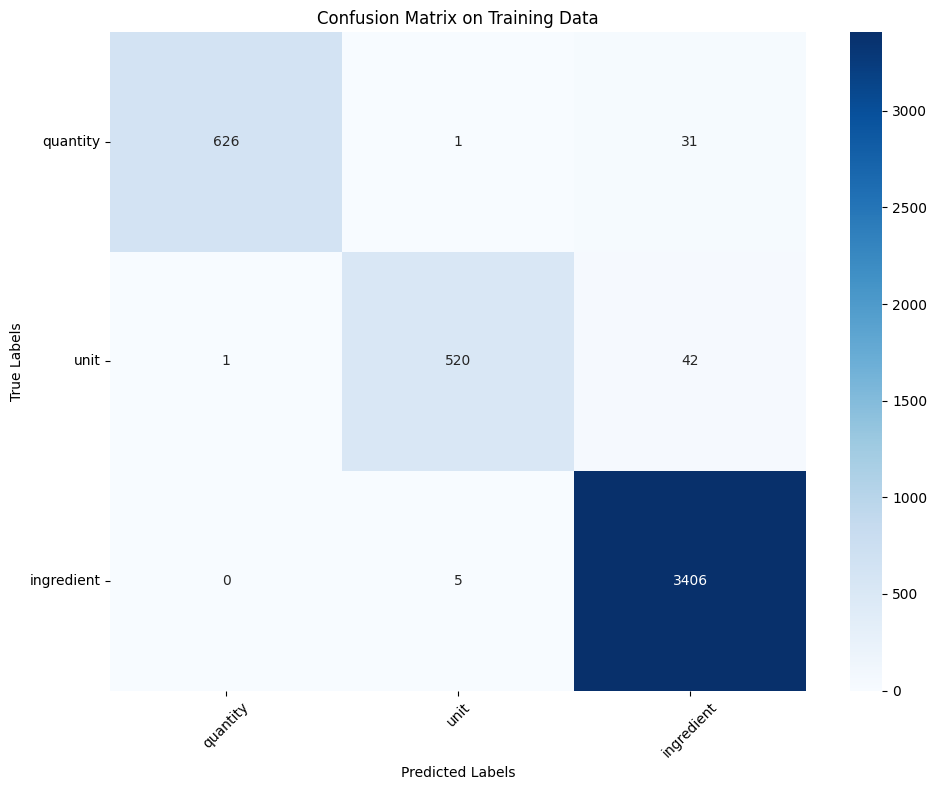

In [ ]:

y_true_flat = [label for seq in y_train_crf for label in seq]
y_pred_flat = [label for seq in y_pred_train for label in seq]

labels = list(crf_model.classes_)  # all possible labels
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Training Data')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [ ]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf_model, 'crf_model.pkl')

['crf_model.pkl']

*italicised text*## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [ ]:
# predict the crf model on validation dataset
X_val_crf = transform_to_crf_format(X_val, X_val_weighted_features)

y_pred_val = crf_model.predict(X_val_crf)


In [ ]:
# specify flat classification report

report = flat_classification_report(y_val, y_pred_val)
report



'              precision    recall  f1-score   support\n\n  ingredient       0.98      1.00      0.99      1611\n    quantity       1.00      0.95      0.97       294\n        unit       0.97      0.92      0.94       244\n\n    accuracy                           0.98      2149\n   macro avg       0.98      0.96      0.97      2149\nweighted avg       0.98      0.98      0.98      2149\n'

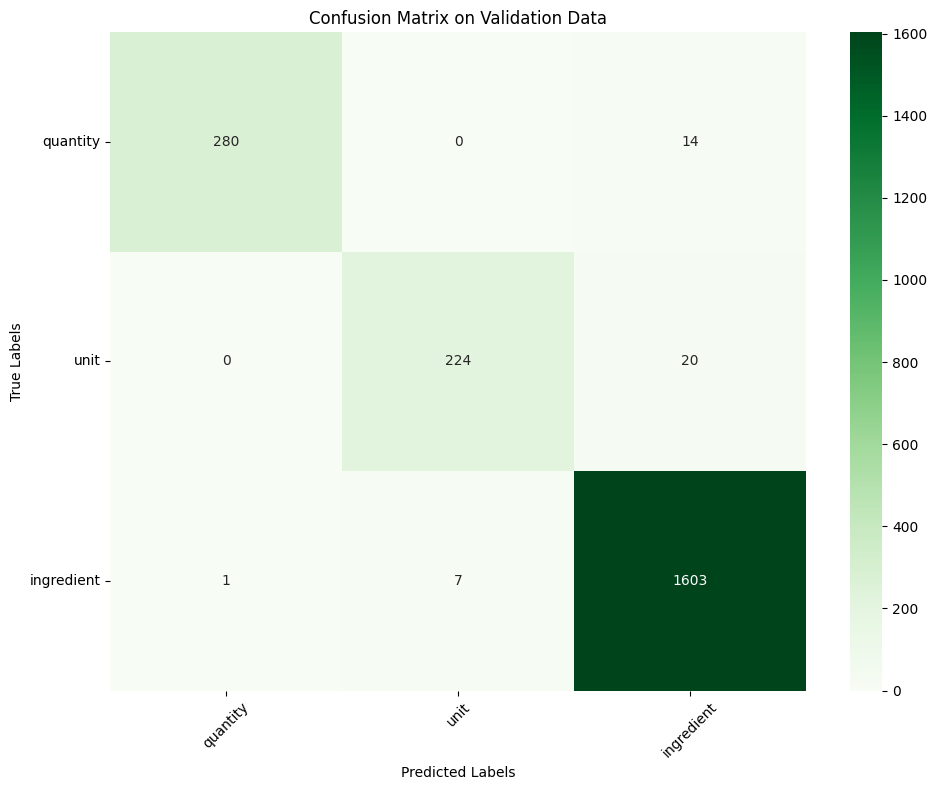

In [ ]:
# create a confusion matrix on validation dataset


y_true_val_flat = [label for seq in y_val for label in seq]
y_pred_val_flat = [label for seq in y_pred_val for label in seq]

labels = list(crf_model.classes_)
cm_val = confusion_matrix(y_true_val_flat, y_pred_val_flat, labels=labels)

# confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Validation Data')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data

# y_true_val_flat = [label for seq in y_val for label in seq]
# y_pred_val_flat = [label for seq in y_pred_val for label in seq]

print("y_true_val_flat", y_true_val_flat)
print("y_pred_val_flat", y_pred_val_flat)

error_data = []

y_true_val_flat ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient',

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

for i in range(len(X_val)):
    tokens = X_val[i]
    true_seq = y_val[i]
    pred_seq = y_pred_val[i]

    for j in range(len(tokens)):
        true_label = true_seq[j]
        pred_label = pred_seq[j]

        if true_label != pred_label:
            token = tokens[j]

            prev_token = tokens[j - 1] if j > 0 else "<START>"
            next_token = tokens[j + 1] if j < len(tokens) - 1 else "<END>"

            #  weight_dict
            weight = weight_dict.get(true_label, 1.0)

            # Store error info
            error_data.append({
                "sequence_index": i,
                "token_index": j,
                "token": token,
                "true_label": true_label,
                "pred_label": pred_label,
                "prev_token": prev_token,
                "next_token": next_token,
                "weight": weight
            })

            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>

> Add blockquote





Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy

error_df = pd.DataFrame(error_data)



In [ ]:
error_df.head()

sequence_index  token_index   token  true_label  pred_label prev_token next_token    weight
0               0            4   small        unit  ingredient         12     onions  8.227353
1               0            7  cloves  ingredient        unit          2     garlic  0.678980
2               0           11   green        unit  ingredient     ginger   chillies  8.227353
3               0           15     tsp        unit  ingredient       leaf        red  8.227353
4               4            5     tsp        unit  ingredient      water       ghee  8.227353

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_val_flat, y_pred_val_flat)
accuracy

0.9804560260586319

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context


error_counts_by_label = error_df['true_label'].value_counts().sort_index()
print("error_counts_by_label",error_counts_by_label)

for label in sorted(set(y_true_val_flat)):
    weight = weight_dict.get(label, 1.0)

    true_for_label = [t == label for t in y_true_val_flat]
    correct_preds = [
        y_true_val_flat[i] == y_pred_val_flat[i] and y_true_val_flat[i] == label
        for i in range(len(y_true_val_flat))
    ]
    label_accuracy = sum(correct_preds) / sum(true_for_label) if sum(true_for_label) > 0 else 0.0

    print(f"{label}: Weight={weight:.2f}, Accuracy={label_accuracy:.4f}")



error_df['context'] = error_df.apply(
    lambda row: f"{row['prev_token']} ← {row['token']} → {row['next_token']}", axis=1
)

display_columns = ['token', 'prev_token', 'next_token', 'true_label', 'pred_label', 'context']

print(error_df[display_columns].head())

error_counts_by_label true_label
ingredient     8
quantity      14
unit          20
Name: count, dtype: int64
ingredient: Weight=0.68, Accuracy=0.9950
quantity: Weight=7.04, Accuracy=0.9524
unit: Weight=8.23, Accuracy=0.9180
    token prev_token next_token  true_label  pred_label                    context
0   small         12     onions        unit  ingredient        12 ← small → onions
1  cloves          2     garlic  ingredient        unit        2 ← cloves → garlic
2   green     ginger   chillies        unit  ingredient  ginger ← green → chillies
3     tsp       leaf        red        unit  ingredient           leaf ← tsp → red
4     tsp      water       ghee        unit  ingredient         water ← tsp → ghee


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.